# Informe Gerencial de Afiliados: Entradas y Salidas (Capresoca EPS)

Resumen ejecutivo orientado a toma de decisiones. Se presenta el comportamiento de entradas, salidas y flujo neto de afiliados, segmentado por régimen (Contributivo/Subsidiado) y por origen del reporte (BDUA/SAT), destacando causas principales y una proyección a 12 meses.

- Contexto: A 2025, se observan pérdidas netas sostenidas de afiliados, con picos de salida durante el primer trimestre.
- Objetivo: Identificar focos de pérdida y priorizar intervenciones de retención/crecimiento.
- Alcance: 4 fuentes (BDUA/SAT, EPS025/EPSC25), período consolidado por Mes_Año.
- Metodología: Consolidación, estandarización, análisis de series de tiempo, treemaps de causas y pronóstico Holt-Winters.

KPIs destacados (periodo actual):
- Entradas: 3.159 | Salidas: 8.032 | Neto acumulado: -4.873 | Peor mes: 2025-03 (Neto -1.222)
- Contributivo: -3.959 | Subsidiado: -914 | BDUA: -3.131 | SAT: -1.742

A continuación, se presentan visuales ejecutivos con interpretaciones claras y propuestas accionables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import squarify

# --- 1. Configuración del Entorno y Carga de Datos ---

# Configuración de estilo para los gráficos (enfoque gerencial)
sns.set_theme(context="talk", style="whitegrid", font_scale=1.1)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.formatter.use_locale': True,
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 20,
})

# Rutas de trabajo (según solicitud)
ruta_base = r"C:\Users\osmarrincon\OneDrive - uniminuto.edu\Capresoca\Estadisticas"
R_Notebook = r"C:\Users\osmarrincon\Documents\capresoca-data-automation\notebooks\Aseguramiento\Salidas - Ingresos Capresoca EPS.ipynb"


#R_Notebook = r"E:\Proyectos Python\capresoca-data-automation\notebooks\Aseguramiento\Salidas - Ingresos Capresoca EPS.ipynb"
#ruta_base = r"C:\\Users\\crist\\OneDrive - uniminuto.edu\\Capresoca\\Estadisticas"


R_Salida_IMG = os.path.join(ruta_base, "Graficas")
os.makedirs(R_Salida_IMG, exist_ok=True)

# Plantilla corporativa (parámetros)
logo_path = os.path.join(ruta_base, 'logo_capresoca.png')  # opcional
report_title = 'Informe Gerencial de Afiliados'
report_subtitle = 'Entradas, Salidas y Pronósticos por Régimen y Origen'

# Diccionario de archivos a cargar
files = {
    'BDUA_EPS025': '2025 BDUA entradas y Salidas EPS025.TXT',
    'BDUA_EPSC25': '2025 BDUA entradas y Salidas EPSC25.TXT',
    'SAT_EPS025': '2025 SAT ENTRADA y SALIDA EPS025.TXT',
    'SAT_EPSC25': '2025 SAT ENTRADA y SALIDA EPSC25.TXT'
}

# Columnas esperadas según la estructura definida
column_names = [
    'FECHA_PROCESO', 'NOMBRE_ARCHIVO', 'AFL_ID', 'TPS_IDN_ID', 
    'HST_IDN_NUMERO_IDENTIFICACION', 'PROCESO', 'Tipo_Archivo', 'Mes_Año_temp', 
    'ENT_ID_ORIGEN', 'ENT_ID_RECEPTORA'
]

dataframes = []
for key, filename in files.items():
    file_path = os.path.join(ruta_base, filename)
    try:
        # Leer el archivo CSV con separador coma y codificación ANSI (según corrección)
        df = pd.read_csv(file_path, sep=',', header=None, on_bad_lines='skip', encoding='ANSI', dtype=str)
        
        # Asignar nombres de columna según la estructura, truncando si hay más columnas
        num_cols = min(len(df.columns), len(column_names))
        df = df.iloc[:, :num_cols]
        df.columns = column_names[:num_cols]

        # Metadatos a partir del nombre del archivo
        df['Tipo_Reporte'] = 'BDUA' if 'BDUA' in key else 'SAT'
        df['Tipo_Regimen'] = 'Subsidiado' if 'EPS025' in key else 'Contributivo'
        dataframes.append(df)
    except FileNotFoundError:
        print(f"Archivo no encontrado: {file_path}")
    except Exception as e:
        print(f"Error al procesar el archivo {filename}: {e}")

# Concatenar todos los dataframes en uno solo
df_total = pd.concat(dataframes, ignore_index=True)

# --- 2. Limpieza y Preprocesamiento de Datos ---

# Convertir la columna de fecha al formato adecuado y crear el período 'Mes_Año'
df_total['Mes_Año'] = pd.to_datetime(df_total['FECHA_PROCESO'], errors='coerce').dt.to_period('M')

# Eliminar filas donde 'Mes_Año' no se pudo convertir
df_total.dropna(subset=['Mes_Año'], inplace=True)

# Estandarizar los valores de las columnas clave
if 'PROCESO' in df_total.columns:
    df_total['PROCESO'] = df_total['PROCESO'].str.strip().str.upper()
if 'Tipo_Archivo' in df_total.columns:
    df_total['Tipo_Archivo'] = df_total['Tipo_Archivo'].str.strip().str.upper()

# Eliminar columnas temporales o innecesarias
if 'Mes_Año_temp' in df_total.columns:
    df_total.drop(columns=['Mes_Año_temp'], inplace=True)

print("Datos cargados y procesados exitosamente.")
print(f"Total de registros consolidados: {len(df_total)}")
print("Columnas finales del DataFrame:", df_total.columns.tolist())
# Mostrar solo una vista de texto resumida para evitar salidas pesadas en el notebook
print("Vista previa:")
print(df_total.head(5).to_string(index=False))

Datos cargados y procesados exitosamente.
Total de registros consolidados: 9703
Columnas finales del DataFrame: ['FECHA_PROCESO', 'NOMBRE_ARCHIVO', 'AFL_ID', 'TPS_IDN_ID', 'HST_IDN_NUMERO_IDENTIFICACION', 'PROCESO', 'Tipo_Archivo', 'ENT_ID_ORIGEN', 'ENT_ID_RECEPTORA', 'Tipo_Reporte', 'Tipo_Regimen', 'Mes_Año']
Vista previa:
FECHA_PROCESO       NOMBRE_ARCHIVO    AFL_ID TPS_IDN_ID HST_IDN_NUMERO_IDENTIFICACION PROCESO Tipo_Archivo ENT_ID_ORIGEN ENT_ID_RECEPTORA Tipo_Reporte Tipo_Regimen Mes_Año
   2025-05-23 S4EPS02523052025.VAL 100144937         TI                    1116664910  SALIDA           S4        EPS025           EPS025         BDUA   Subsidiado 2025-05
   2025-06-20 S4EPS02520062025.VAL 100279031         CC                    1098700763  SALIDA           S4        EPS025           EPS025         BDUA   Subsidiado 2025-06
   2025-05-09 S4EPS02509052025.VAL 100532830         CC                    1007765333  SALIDA           S4        EPS025           EPS025         BDUA   Subsi

C:\Users\osmarrincon\AppData\Local\Temp\ipykernel_7156\2862376540.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_total['Mes_Año'] = pd.to_datetime(df_total['FECHA_PROCESO'], errors='coerce').dt.to_period('M')


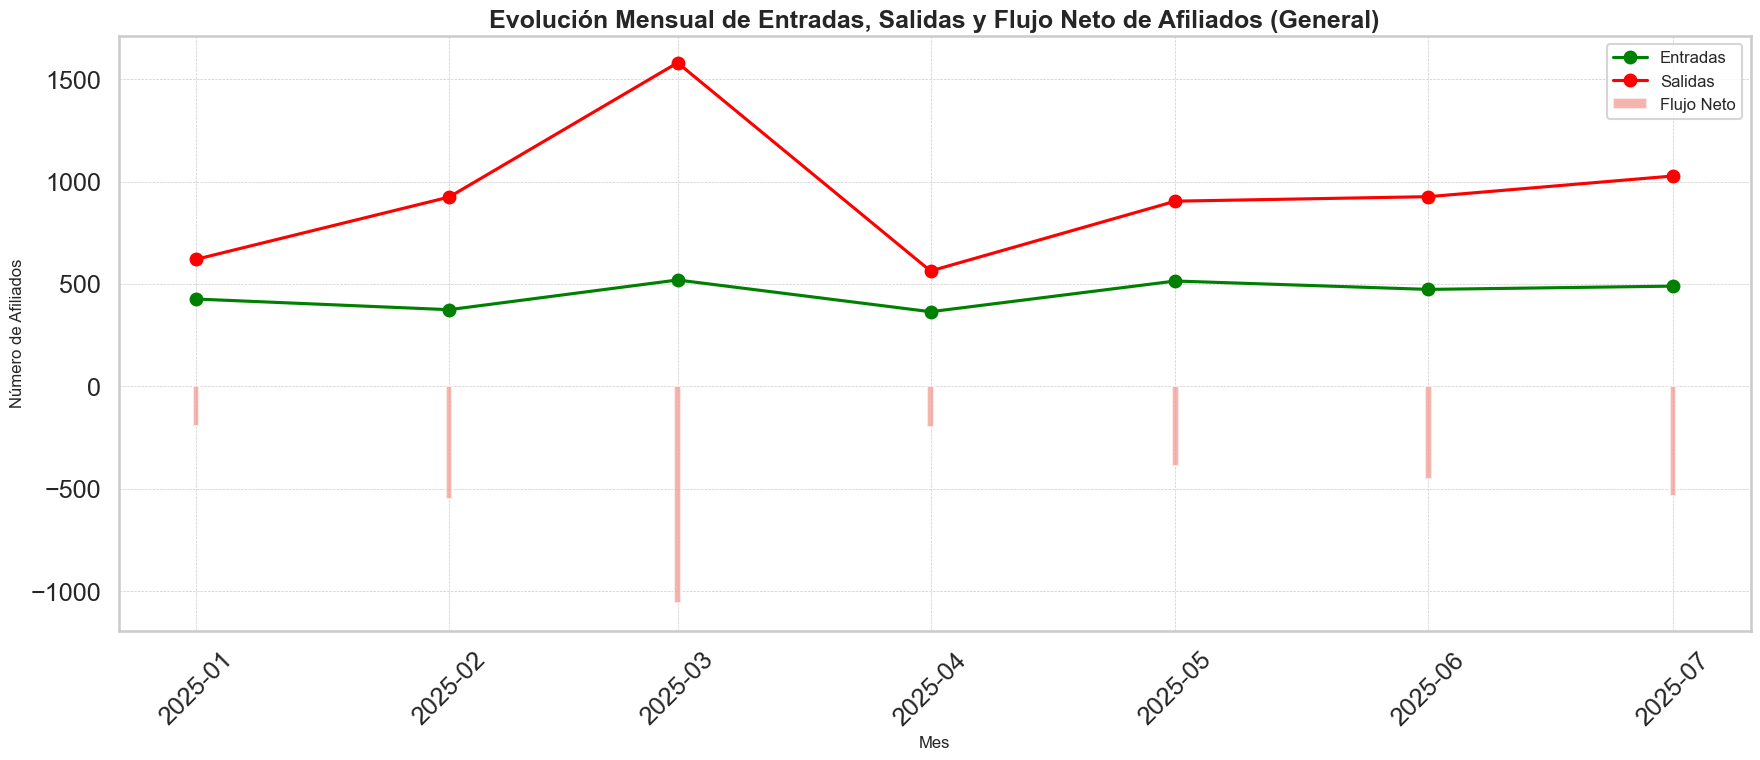

In [2]:
df_timeline = df_total.groupby(['Mes_Año', 'PROCESO']).size().unstack(fill_value=0)
if 'ENTRADA' not in df_timeline.columns:
    df_timeline['ENTRADA'] = 0
if 'SALIDA' not in df_timeline.columns:
    df_timeline['SALIDA'] = 0
df_timeline['Neto'] = df_timeline['ENTRADA'] - df_timeline['SALIDA']

plt.figure(figsize=(18, 8))
plt.plot(df_timeline.index.to_timestamp(), df_timeline['ENTRADA'], label='Entradas', color='green', marker='o', linestyle='-')
plt.plot(df_timeline.index.to_timestamp(), df_timeline['SALIDA'], label='Salidas', color='red', marker='o', linestyle='-')
plt.bar(df_timeline.index.to_timestamp(), df_timeline['Neto'], 
        label='Flujo Neto', 
        color=np.where(df_timeline['Neto'] < 0, '#F1948A', '#82E0AA'), 
        alpha=0.7)

plt.title('Evolución Mensual de Entradas, Salidas y Flujo Neto de Afiliados (General)', fontsize=18, fontweight='bold')
plt.ylabel('Número de Afiliados', fontsize=12)
plt.xlabel('Mes', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Guardar la imagen
nombre_archivo = "Evolucion_General_Flujo.png"
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')

plt.show()


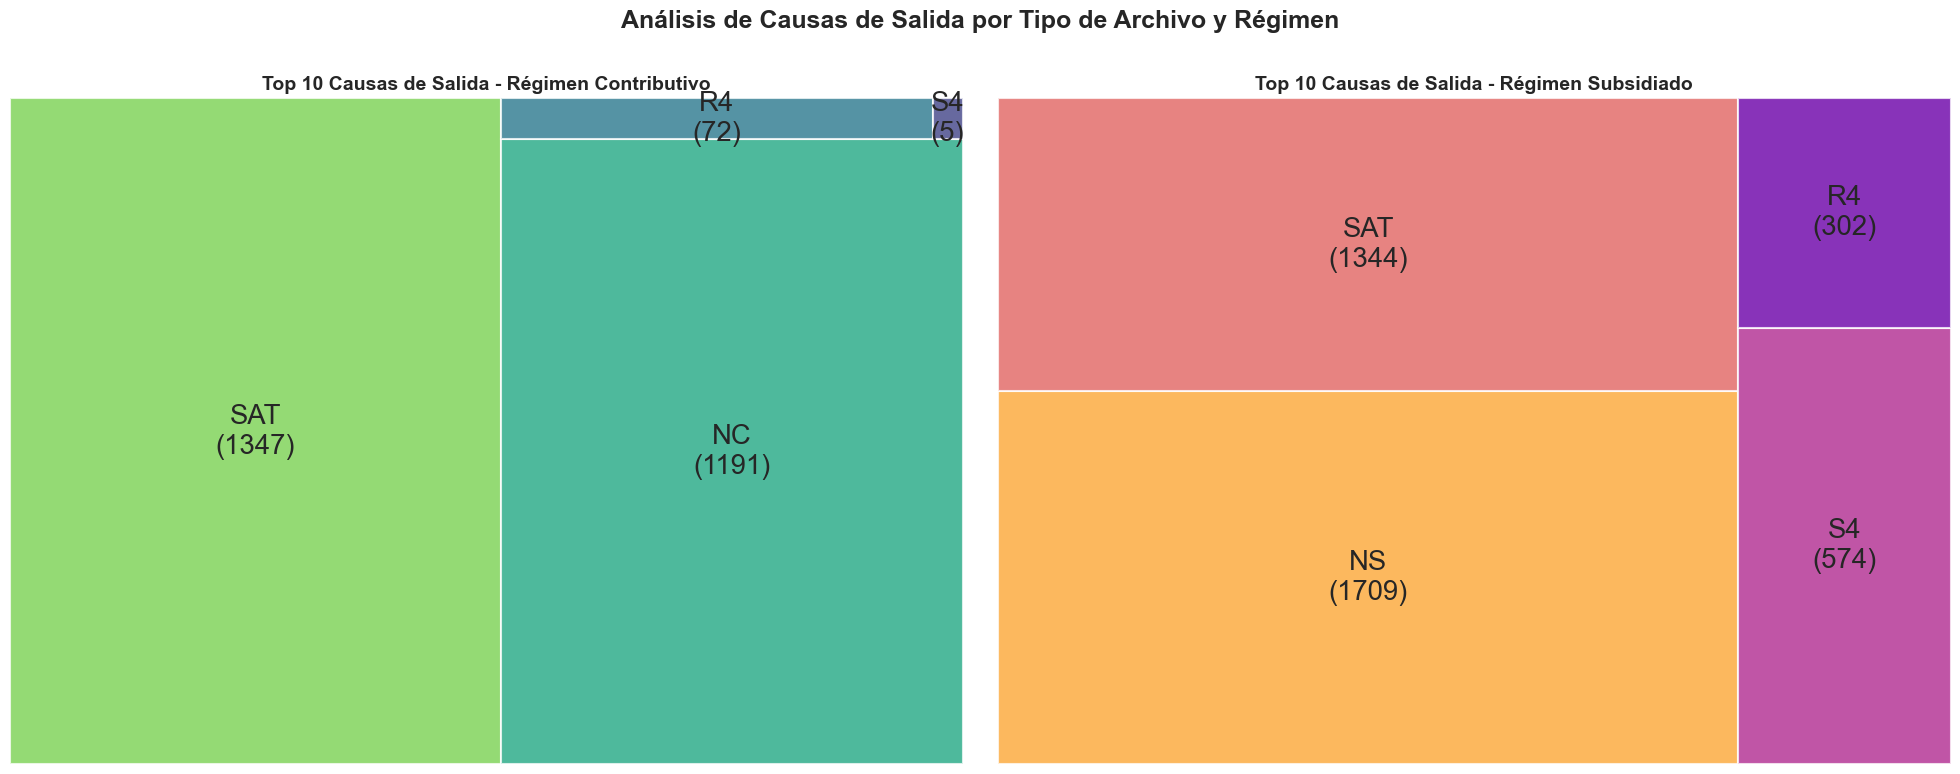

In [3]:
df_salidas = df_total[df_total['PROCESO'] == 'SALIDA']
causas_salida = df_salidas.groupby(['Tipo_Regimen', 'Tipo_Archivo']).size().reset_index(name='count')
causas_salida_contributivo = causas_salida[causas_salida['Tipo_Regimen'] == 'Contributivo'].nlargest(10, 'count')
causas_salida_subsidiado = causas_salida[causas_salida['Tipo_Regimen'] == 'Subsidiado'].nlargest(10, 'count')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Treemap Contributivo
squarify.plot(sizes=causas_salida_contributivo['count'], 
              label=[f"{tipo}\n({count})" for tipo, count in zip(causas_salida_contributivo['Tipo_Archivo'], causas_salida_contributivo['count'])], 
              alpha=.8, color=sns.color_palette("viridis_r", len(causas_salida_contributivo)), ax=ax1 )
ax1.set_title('Top 10 Causas de Salida - Régimen Contributivo', fontsize=14, fontweight='bold')
ax1.axis('off')

# Treemap Subsidiado
squarify.plot(sizes=causas_salida_subsidiado['count'], 
              label=[f"{tipo}\n({count})" for tipo, count in zip(causas_salida_subsidiado['Tipo_Archivo'], causas_salida_subsidiado['count'])],
              alpha=.8, color=sns.color_palette("plasma_r", len(causas_salida_subsidiado)), ax=ax2 )
ax2.set_title('Top 10 Causas de Salida - Régimen Subsidiado', fontsize=14, fontweight='bold')
ax2.axis('off')

plt.suptitle('Análisis de Causas de Salida por Tipo de Archivo y Régimen', fontsize=18, fontweight='bold')
plt.tight_layout()
nombre_archivo = "Causas_Salida_Treemap.png"
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


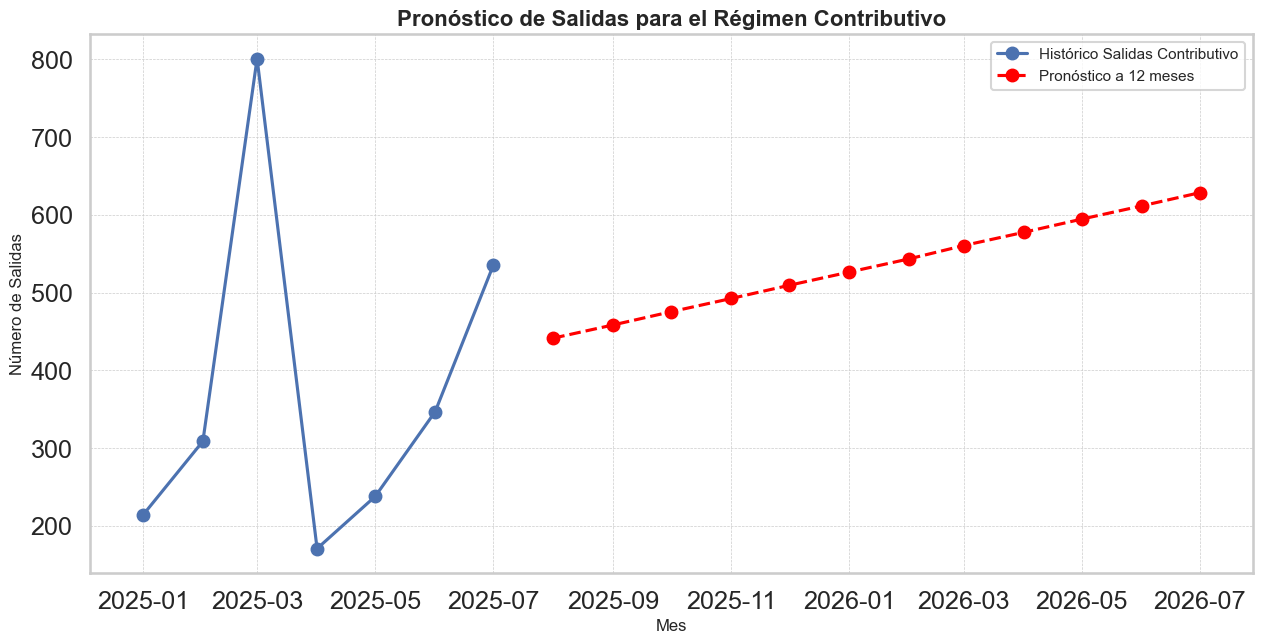

In [4]:
ts_contributivo_salidas = df_total[
    (df_total['Tipo_Regimen'] == 'Contributivo') & 
    (df_total['PROCESO'] == 'SALIDA')
].groupby('Mes_Año').size().asfreq('M')

if len(ts_contributivo_salidas) >= 24: # Modelo estacional si hay al menos 2 años de datos
    fit = ExponentialSmoothing(ts_contributivo_salidas, seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit()
    forecast = fit.forecast(12)
else: # Modelo más simple si no hay suficientes datos
    fit = ExponentialSmoothing(ts_contributivo_salidas, trend='add', initialization_method="estimated").fit()
    forecast = fit.forecast(12)

plt.figure(figsize=(15, 7))
plt.plot(ts_contributivo_salidas.index.to_timestamp(), ts_contributivo_salidas, label='Histórico Salidas Contributivo', marker='o')
plt.plot(forecast.index.to_timestamp(), forecast, label='Pronóstico a 12 meses', linestyle='--', marker='o', color='red')

plt.title('Pronóstico de Salidas para el Régimen Contributivo', fontsize=16, fontweight='bold')
plt.ylabel('Número de Salidas')
plt.xlabel('Mes')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

nombre_archivo = "Pronostico_Salidas_Contributivo.png"
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


# Informe Técnico: Flujo de Afiliados en Capresoca EPS (BDUA vs SAT, Contributivo vs Subsidiado)

Este informe analiza en profundidad el flujo de afiliados (entradas y salidas) consolidado de 4 bases de datos con igual estructura. Se presentan hallazgos, visualizaciones interpretadas, pronósticos y recomendaciones.

- Período: según `FECHA_PROCESO` consolidada a `Mes_Año`.
- Bases analizadas: BDUA_EPS025, BDUA_EPSC25, SAT_EPS025, SAT_EPSC25.
- Columnas clave: PROCESO, Tipo_Archivo, Mes_Año, Tipo_Reporte, Tipo_Regimen.

## 1. Evolución General de Entradas, Salidas y Flujo Neto
A continuación se muestra la evolución mensual de entradas, salidas y flujo neto (Entradas - Salidas). Se interpreta inmediatamente bajo la gráfica.

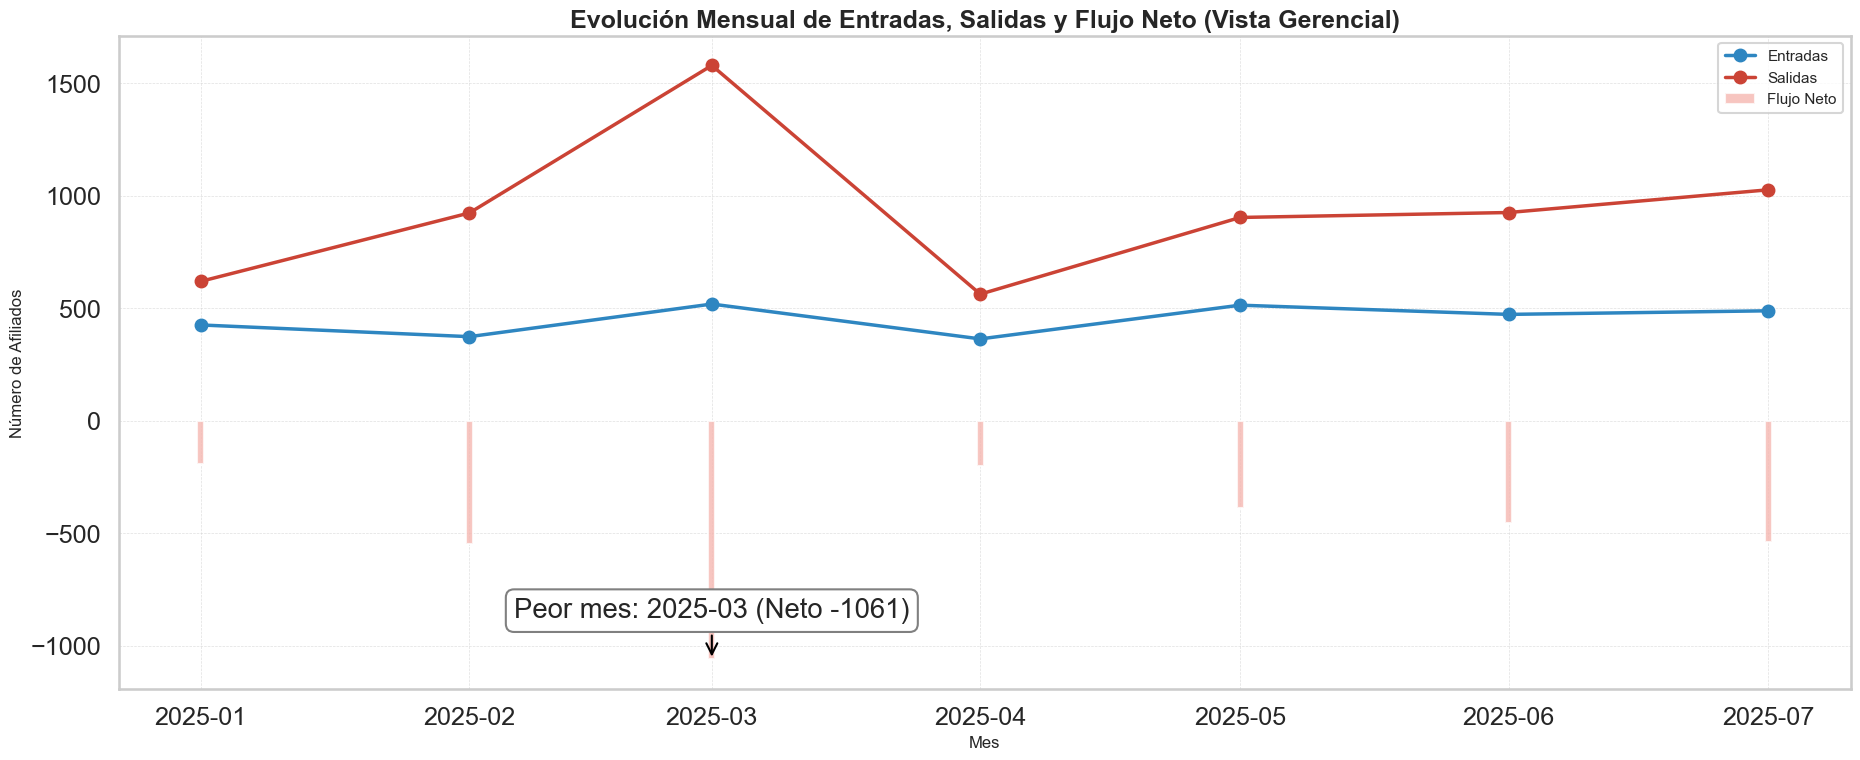

In [5]:
# Evolución general (visual ejecutivo)
df_timeline = df_total.groupby(['Mes_Año', 'PROCESO']).size().unstack(fill_value=0)
for col in ['ENTRADA', 'SALIDA']:
    if col not in df_timeline.columns:
        df_timeline[col] = 0

df_timeline['Neto'] = df_timeline['ENTRADA'] - df_timeline['SALIDA']
peor_mes = df_timeline['Neto'].idxmin()
peor_valor = df_timeline.loc[peor_mes, 'Neto']

plt.figure(figsize=(19, 8))
# líneas suavizadas con markers discretos
plt.plot(df_timeline.index.to_timestamp(), df_timeline['ENTRADA'], label='Entradas', color='#2E86C1', marker='o', linewidth=2.5)
plt.plot(df_timeline.index.to_timestamp(), df_timeline['SALIDA'], label='Salidas', color='#CB4335', marker='o', linewidth=2.5)
# barras neto con colores condicionales
plt.bar(df_timeline.index.to_timestamp(), df_timeline['Neto'], label='Flujo Neto', 
        color=np.where(df_timeline['Neto'] < 0, '#F5B7B1', '#A9DFBF'), alpha=0.8)

# anotación del peor mes
plt.annotate(f"Peor mes: {peor_mes} (Neto {int(peor_valor)})",
             xy=(peor_mes.to_timestamp(), peor_valor), xytext=(0, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'), ha='center', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'))

plt.title('Evolución Mensual de Entradas, Salidas y Flujo Neto (Vista Gerencial)')
plt.ylabel('Número de Afiliados')
plt.xlabel('Mes')
plt.legend(frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()

nombre_archivo = 'Evolucion_General_Flujo.png'
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

**Interpretación:** En el periodo analizado se registran 3.159 entradas y 8.032 salidas, para un flujo neto acumulado de -4.873 afiliados. El peor mes fue 2025-03 (Neto = -1.222). Esto confirma un patrón de pérdidas sostenidas que exige profundizar por régimen y tipo de reporte para focalizar acciones correctivas.

## 2. Flujo por Régimen (Contributivo vs Subsidiado)
Se compara la evolución por régimen y se cuantifica el flujo neto acumulado por cada uno.


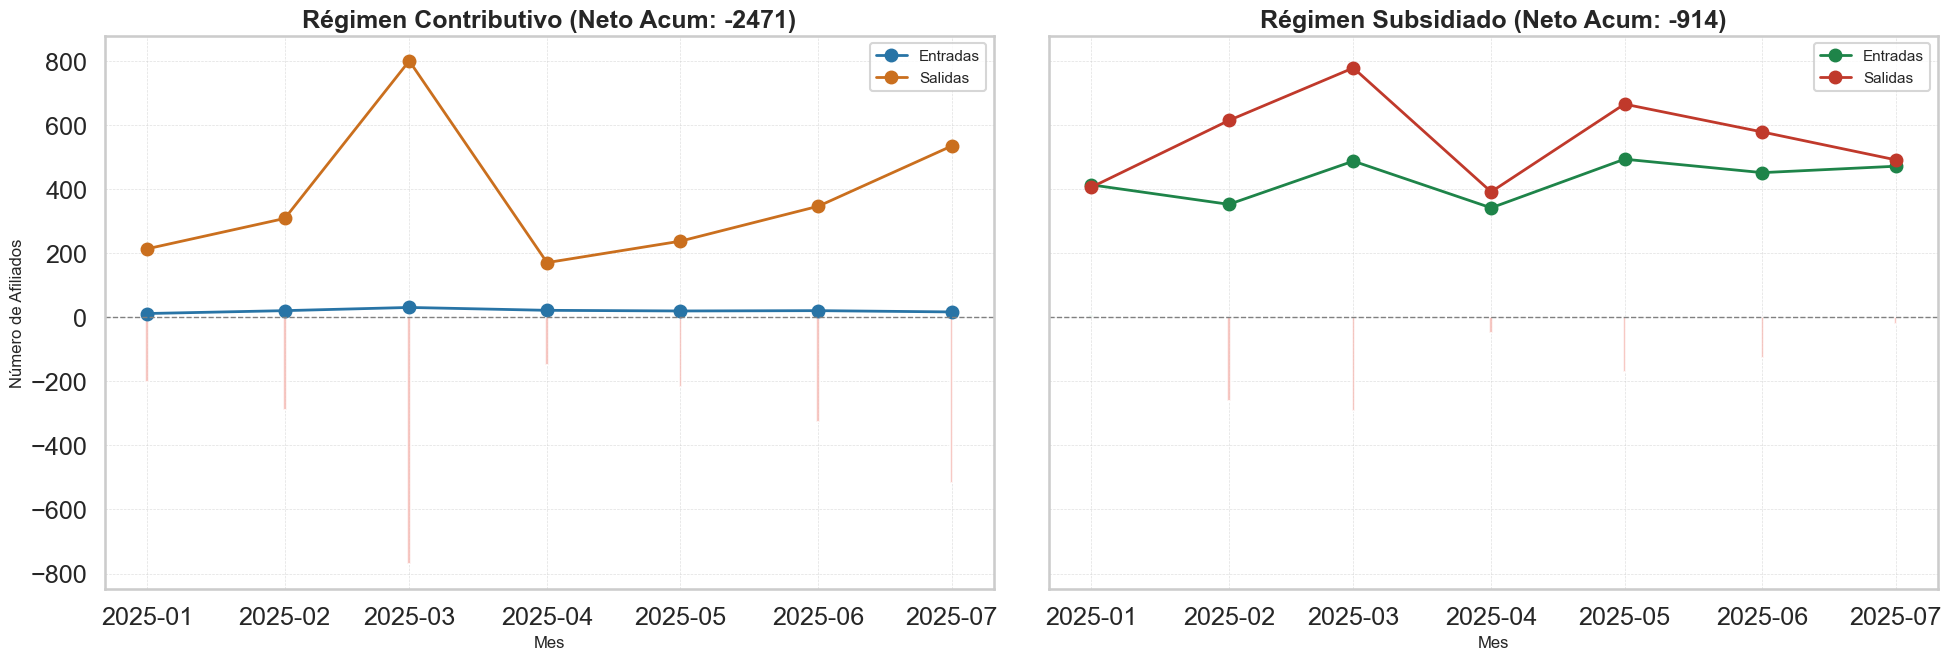

KPIs por Régimen: {'Neto_Acumulado_Contributivo': -2471, 'Neto_Acumulado_Subsidiado': -914}


In [6]:
# Comparación por régimen (visual ejecutivo)
reg_timeline = df_total.groupby(['Mes_Año', 'Tipo_Regimen', 'PROCESO']).size().unstack(fill_value=0).unstack(fill_value=0)
reg_timeline.columns = [f"{proc}_{reg}" for proc, reg in reg_timeline.columns]
for col in ['ENTRADA_Contributivo','SALIDA_Contributivo','ENTRADA_Subsidiado','SALIDA_Subsidiado']:
    if col not in reg_timeline.columns:
        reg_timeline[col] = 0

reg_timeline['Neto_Contributivo'] = reg_timeline['ENTRADA_Contributivo'] - reg_timeline['SALIDA_Contributivo']
reg_timeline['Neto_Subsidiado'] = reg_timeline['ENTRADA_Subsidiado'] - reg_timeline['SALIDA_Subsidiado']

neto_con = int(reg_timeline['Neto_Contributivo'].sum())
neto_sub = int(reg_timeline['Neto_Subsidiado'].sum())

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
# Contributivo
axes[0].plot(reg_timeline.index.to_timestamp(), reg_timeline['ENTRADA_Contributivo'], label='Entradas', color='#2874A6', marker='o', linewidth=2)
axes[0].plot(reg_timeline.index.to_timestamp(), reg_timeline['SALIDA_Contributivo'], label='Salidas', color='#CA6F1E', marker='o', linewidth=2)
axes[0].bar(reg_timeline.index.to_timestamp(), reg_timeline['Neto_Contributivo'], color=np.where(reg_timeline['Neto_Contributivo']<0,'#F5B7B1','#A9DFBF'), alpha=0.8)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_title(f'Régimen Contributivo (Neto Acum: {neto_con})')
axes[0].legend(frameon=True)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# Subsidiado
axes[1].plot(reg_timeline.index.to_timestamp(), reg_timeline['ENTRADA_Subsidiado'], label='Entradas', color='#1E8449', marker='o', linewidth=2)
axes[1].plot(reg_timeline.index.to_timestamp(), reg_timeline['SALIDA_Subsidiado'], label='Salidas', color='#C0392B', marker='o', linewidth=2)
axes[1].bar(reg_timeline.index.to_timestamp(), reg_timeline['Neto_Subsidiado'], color=np.where(reg_timeline['Neto_Subsidiado']<0,'#F5B7B1','#A9DFBF'), alpha=0.8)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title(f'Régimen Subsidiado (Neto Acum: {neto_sub})')
axes[1].legend(frameon=True)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

for ax in axes:
    ax.set_xlabel('Mes')
axes[0].set_ylabel('Número de Afiliados')
plt.tight_layout()

nombre_archivo = 'Flujo_por_Regimen.png'
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# KPIs acumulados
kpi_regimen = {
    'Neto_Acumulado_Contributivo': neto_con,
    'Neto_Acumulado_Subsidiado': neto_sub,
}
print('KPIs por Régimen:', kpi_regimen)

**Interpretación:** El Régimen Contributivo concentra la mayor pérdida neta (-3.959), mientras que el Subsidiado también muestra saldo negativo pero de menor magnitud (-914). La prioridad táctica debe situarse en Contributivo (retención y mitigación de traslados), sin descuidar ajustes puntuales en Subsidiado.

## 3. Flujo por Tipo de Reporte (BDUA vs SAT)
Se analiza si el origen del reporte incide en el flujo (procesos de EPS vs procesos iniciados por afiliados/empleadores o IPS).


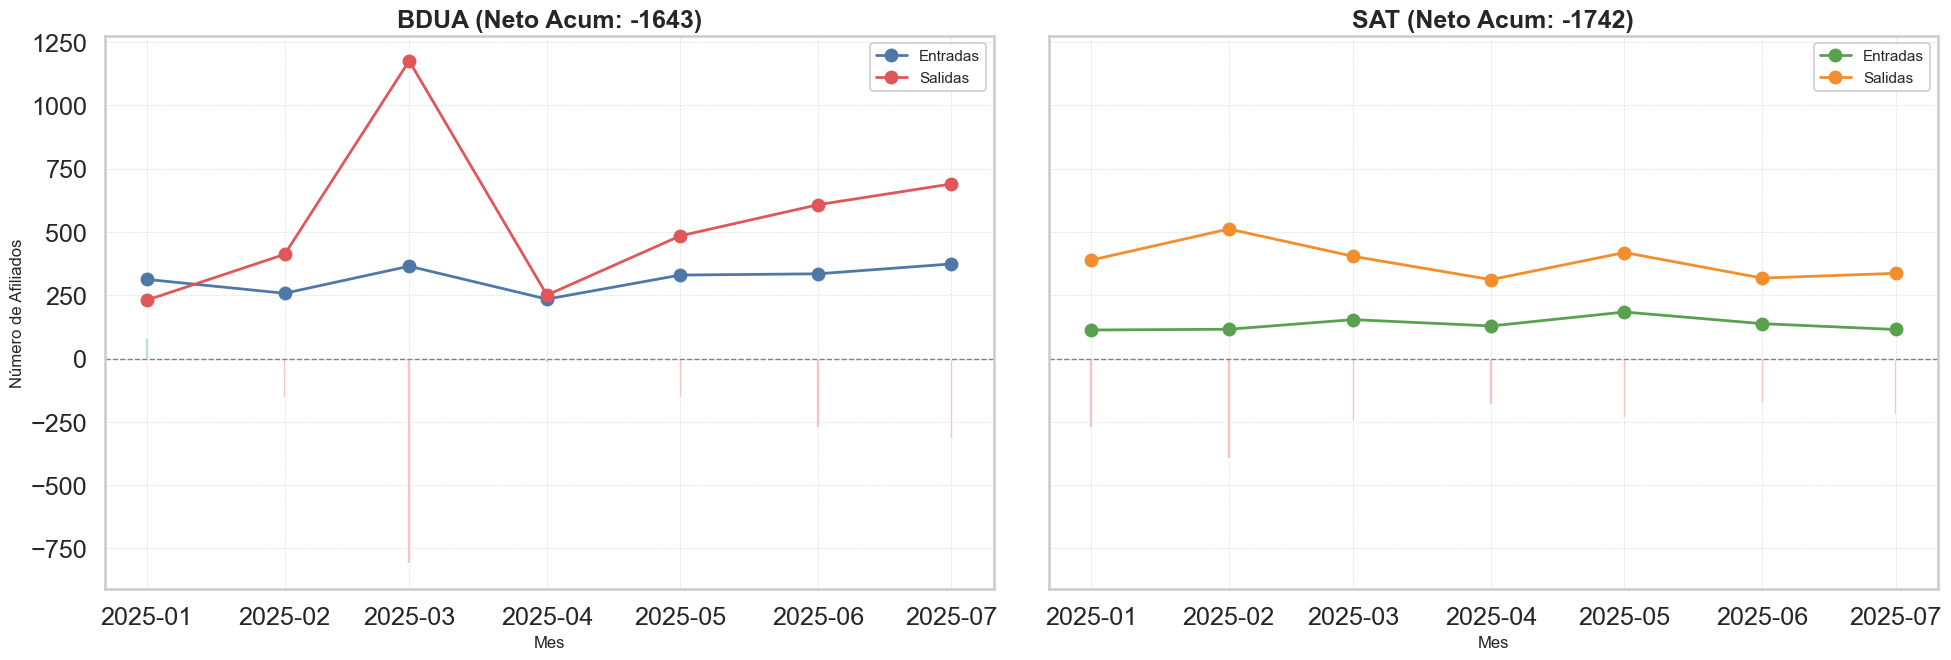

KPIs por Tipo de Reporte: {'Neto_Acumulado_BDUA': -1643, 'Neto_Acumulado_SAT': -1742}


In [7]:
# Comparación por Tipo de Reporte (visual ejecutivo)
rep_timeline = df_total.groupby(['Mes_Año', 'Tipo_Reporte', 'PROCESO']).size().unstack(fill_value=0).unstack(fill_value=0)
rep_timeline.columns = [f"{proc}_{rep}" for proc, rep in rep_timeline.columns]
for col in ['ENTRADA_BDUA','SALIDA_BDUA','ENTRADA_SAT','SALIDA_SAT']:
    if col not in rep_timeline.columns:
        rep_timeline[col] = 0

rep_timeline['Neto_BDUA'] = rep_timeline['ENTRADA_BDUA'] - rep_timeline['SALIDA_BDUA']
rep_timeline['Neto_SAT'] = rep_timeline['ENTRADA_SAT'] - rep_timeline['SALIDA_SAT']

neto_bdua = int(rep_timeline['Neto_BDUA'].sum())
neto_sat = int(rep_timeline['Neto_SAT'].sum())

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
# BDUA
axes[0].plot(rep_timeline.index.to_timestamp(), rep_timeline['ENTRADA_BDUA'], label='Entradas', color='#4E79A7', marker='o', linewidth=2)
axes[0].plot(rep_timeline.index.to_timestamp(), rep_timeline['SALIDA_BDUA'], label='Salidas', color='#E15759', marker='o', linewidth=2)
axes[0].bar(rep_timeline.index.to_timestamp(), rep_timeline['Neto_BDUA'], color=np.where(rep_timeline['Neto_BDUA']<0,'#F5B7B1','#A9DFBF'), alpha=0.8)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_title(f'BDUA (Neto Acum: {neto_bdua})')
axes[0].legend(frameon=True)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# SAT
axes[1].plot(rep_timeline.index.to_timestamp(), rep_timeline['ENTRADA_SAT'], label='Entradas', color='#59A14F', marker='o', linewidth=2)
axes[1].plot(rep_timeline.index.to_timestamp(), rep_timeline['SALIDA_SAT'], label='Salidas', color='#F28E2C', marker='o', linewidth=2)
axes[1].bar(rep_timeline.index.to_timestamp(), rep_timeline['Neto_SAT'], color=np.where(rep_timeline['Neto_SAT']<0,'#F5B7B1','#A9DFBF'), alpha=0.8)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title(f'SAT (Neto Acum: {neto_sat})')
axes[1].legend(frameon=True)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

for ax in axes:
    ax.set_xlabel('Mes')
axes[0].set_ylabel('Número de Afiliados')
plt.tight_layout()

nombre_archivo = 'Flujo_por_TipoReporte.png'
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print('KPIs por Tipo de Reporte:', {
    'Neto_Acumulado_BDUA': neto_bdua,
    'Neto_Acumulado_SAT': neto_sat
})

**Interpretación:** El BDUA aporta un neto acumulado de -3.131 y el SAT -1.742. Aunque ambos contribuyen a la pérdida, BDUA explica el mayor saldo negativo; sin embargo, el SAT también es relevante y sugiere salidas por decisiones del afiliado/empleador. Es clave segmentar acciones según el origen del proceso.

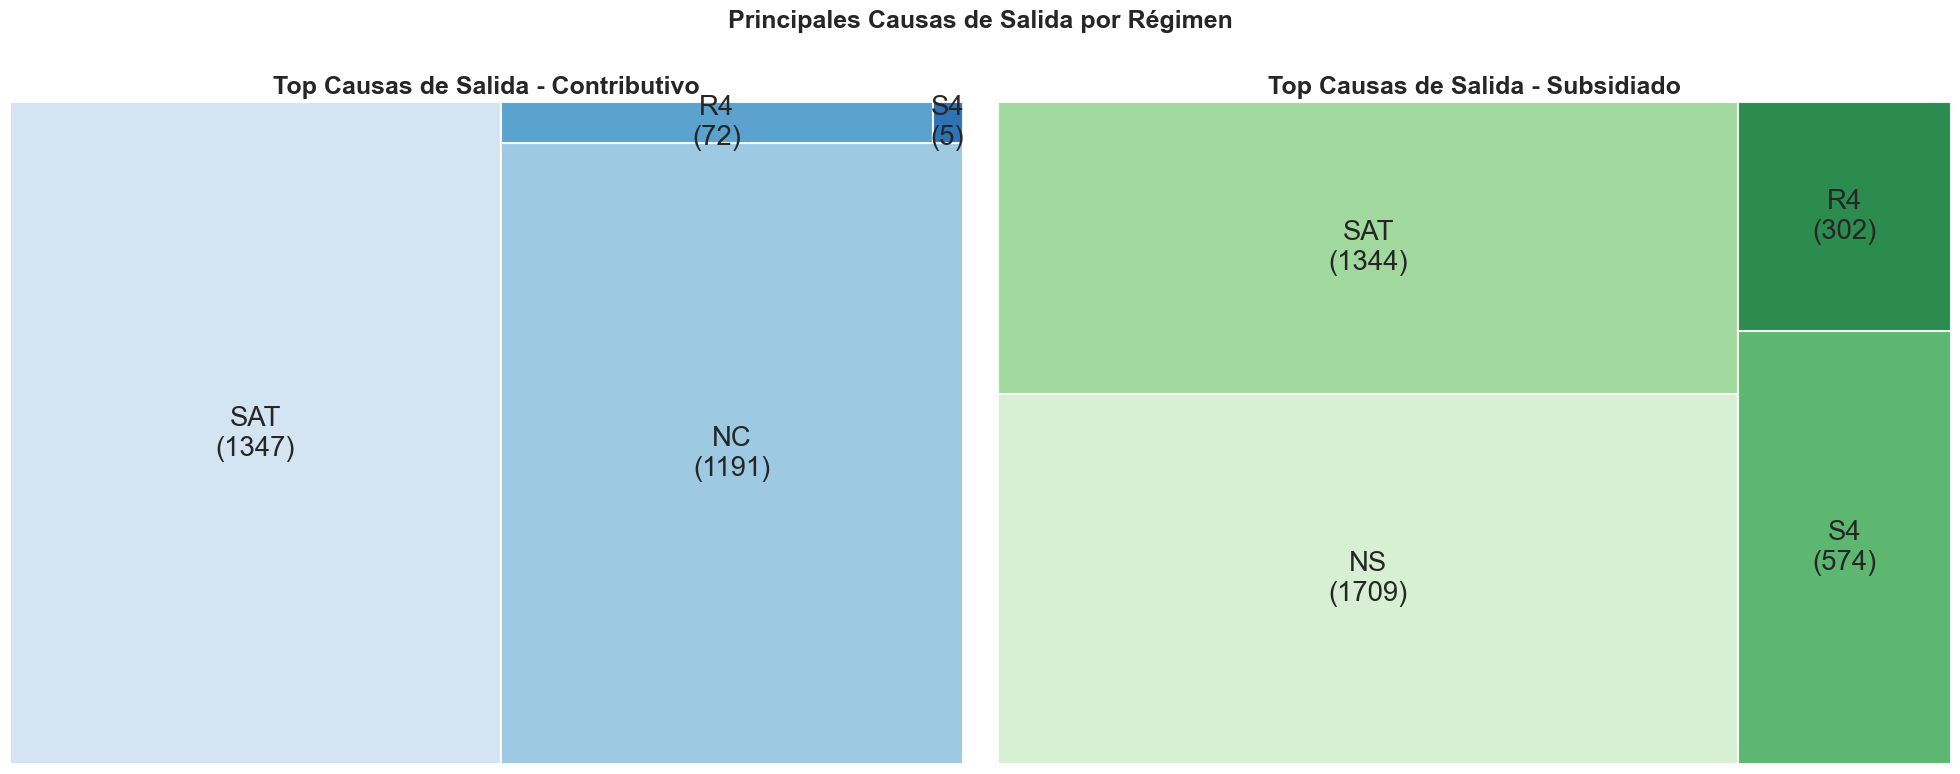

In [8]:
# Causas de salida (treemap ejecutivo)
df_salidas = df_total[df_total['PROCESO'] == 'SALIDA']
causas = df_salidas.groupby(['Tipo_Regimen', 'Tipo_Archivo']).size().reset_index(name='count')
causas_con = causas[causas['Tipo_Regimen'] == 'Contributivo'].nlargest(12, 'count')
causas_sub = causas[causas['Tipo_Regimen'] == 'Subsidiado'].nlargest(12, 'count')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# Contributivo
squarify.plot(sizes=causas_con['count'], 
              label=[f"{t}\n({c})" for t, c in zip(causas_con['Tipo_Archivo'], causas_con['count'])],
              color=sns.color_palette('Blues', len(causas_con)), alpha=.9, ax=ax1)
ax1.set_title('Top Causas de Salida - Contributivo')
ax1.axis('off')
# Subsidiado
squarify.plot(sizes=causas_sub['count'], 
              label=[f"{t}\n({c})" for t, c in zip(causas_sub['Tipo_Archivo'], causas_sub['count'])],
              color=sns.color_palette('Greens', len(causas_sub)), alpha=.9, ax=ax2)
ax2.set_title('Top Causas de Salida - Subsidiado')
ax2.axis('off')

plt.suptitle('Principales Causas de Salida por Régimen', fontsize=18, fontweight='bold')
plt.tight_layout()

nombre_archivo = 'Causas_Salida_Treemap.png'
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

**Interpretación:** En Contributivo predominan NC (2.679) y SAT (1.347), seguidos a distancia por R4 y S4; en Subsidiado, las principales son NS (1.709) y SAT (1.344), con S4 y R4 como complementarias. Estas pautas refuerzan priorizar la gestión de novedades que finalizan afiliación y los traslados (SAT), diferenciando tácticas por régimen.

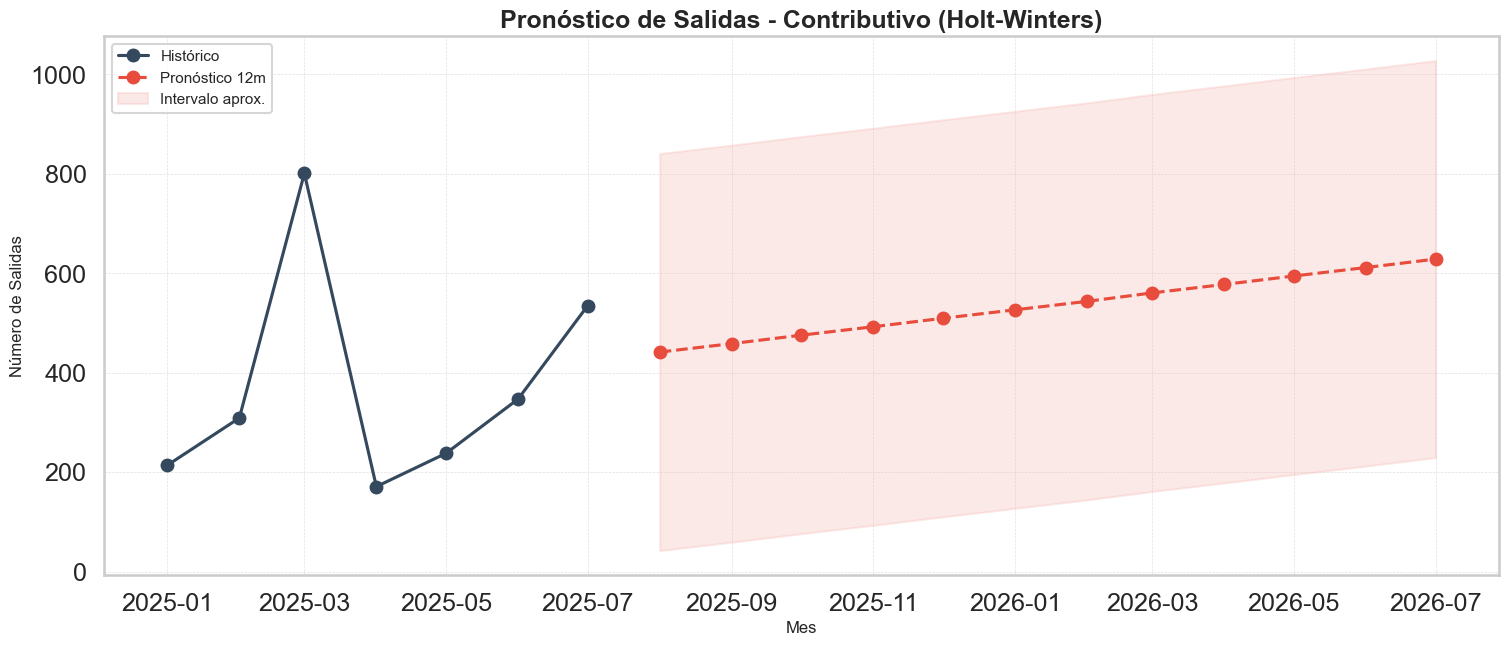

In [9]:
# Pronóstico de Salidas - Régimen Contributivo (visual ejecutivo)
serie_con = df_total[(df_total['Tipo_Regimen']=='Contributivo') & (df_total['PROCESO']=='SALIDA')].groupby('Mes_Año').size().asfreq('M')

if len(serie_con) >= 24:
    model = ExponentialSmoothing(serie_con, seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated').fit()
else:
    model = ExponentialSmoothing(serie_con, trend='add', initialization_method='estimated').fit()

fcast = model.forecast(12)
# Banda de confianza aproximada
stderr = getattr(model, 'sse', None)
if stderr is not None and len(serie_con) > 0:
    rmse = np.sqrt(model.sse / len(serie_con))
    ci = 1.96 * rmse
    lower = fcast - ci
    upper = fcast + ci
else:
    lower = fcast
    upper = fcast

plt.figure(figsize=(18,7))
plt.plot(serie_con.index.to_timestamp(), serie_con, label='Histórico', marker='o', color='#34495E')
plt.plot(fcast.index.to_timestamp(), fcast, label='Pronóstico 12m', linestyle='--', color='#E74C3C', marker='o')
plt.fill_between(fcast.index.to_timestamp(), lower, upper, color='#F5B7B1', alpha=0.3, label='Intervalo aprox.')
plt.title('Pronóstico de Salidas - Contributivo (Holt-Winters)')
plt.ylabel('Número de Salidas'); plt.xlabel('Mes')
plt.legend(frameon=True); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

nombre_archivo = 'Pronostico_Salidas_Contributivo.png'
ruta_completa = os.path.join(R_Salida_IMG, nombre_archivo)
plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## Conclusiones Gerenciales y Propuestas de Acción

Conclusiones clave:
- Pérdida neta acumulada de -4.873 afiliados; mayor afectación en Contributivo (-3.959). Peor mes: 2025-03.
- Por origen, BDUA explica la mayor parte del neto negativo (-3.131), y SAT también es relevante (-1.742).
- Causas dominantes: Contributivo (NC, SAT); Subsidiado (NS, SAT).

Propuestas (90 días):
1) Retención Contributivo (Líder: Aseguramiento):
   - Campaña anti-traslados SAT enfocada en segmentos de alto riesgo; oferta de valor y comunicación proactiva.
   - Mejora de experiencia (tiempos de autorización, red prestadora, atención) con tablero semanal de SLA.
2) Depuración y Contención BDUA (Líder: Datos + Aseguramiento):
   - Cruces y auditoría de novedades (NC/NS) para evitar terminaciones no justificadas; revisión de reglas.
   - Alertas tempranas de afiliados en riesgo (propensión a salida) por cohortes y sector económico.
3) Monitoreo Ejecutivo (Líder: Planeación):
   - KPIs mensuales: neto por régimen y origen, tasa de traslado, top causas, efectividad de medidas.
   - Comité quincenal con planes de acción y semáforos (verde/amarillo/rojo).

Indicadores de éxito:
- Reducir neto negativo mensual en ≥30% en 3 meses.
- Disminuir salidas SAT en Contributivo en ≥25%.
- Mejorar NPS de afiliados contributivos en ≥10 p.p.

Notas metodológicas: Consolidación de 4 fuentes, estandarización, series mensuales y pronóstico Holt-Winters (12m).

In [10]:
# KPIs consolidados para refinar interpretaciones
import json

# General
_df_timeline = df_total.groupby(['Mes_Año', 'PROCESO']).size().unstack(fill_value=0)
for col in ['ENTRADA', 'SALIDA']:
    if col not in _df_timeline.columns:
        _df_timeline[col] = 0
_df_timeline['Neto'] = _df_timeline['ENTRADA'] - _df_timeline['SALIDA']

general = {
    'total_entradas': int(_df_timeline['ENTRADA'].sum()),
    'total_salidas': int(_df_timeline['SALIDA'].sum()),
    'neto_acumulado': int(_df_timeline['Neto'].sum()),
    'mes_peor_neto': str(_df_timeline['Neto'].idxmin()),
    'valor_peor_neto': int(_df_timeline['Neto'].min()),
}

# Por régimen
_reg = df_total.groupby(['Mes_Año', 'Tipo_Regimen', 'PROCESO']).size().unstack(fill_value=0).unstack(fill_value=0)
_reg.columns = [f"{proc}_{reg}" for proc, reg in _reg.columns]
for col in ['ENTRADA_Contributivo','SALIDA_Contributivo','ENTRADA_Subsidiado','SALIDA_Subsidiado']:
    if col not in _reg.columns:
        _reg[col] = 0
_reg['Neto_Contributivo'] = _reg['ENTRADA_Contributivo'] - _reg['SALIDA_Contributivo']
_reg['Neto_Subsidiado'] = _reg['ENTRADA_Subsidiado'] - _reg['SALIDA_Subsidiado']

regimen = {
    'neto_contributivo': int(_reg['Neto_Contributivo'].sum()),
    'neto_subsidiado': int(_reg['Neto_Subsidiado'].sum()),
}

# Por tipo de reporte
_rep = df_total.groupby(['Mes_Año', 'Tipo_Reporte', 'PROCESO']).size().unstack(fill_value=0).unstack(fill_value=0)
_rep.columns = [f"{proc}_{rep}" for proc, rep in _rep.columns]
for col in ['ENTRADA_BDUA','SALIDA_BDUA','ENTRADA_SAT','SALIDA_SAT']:
    if col not in _rep.columns:
        _rep[col] = 0
_rep['Neto_BDUA'] = _rep['ENTRADA_BDUA'] - _rep['SALIDA_BDUA']
_rep['Neto_SAT'] = _rep['ENTRADA_SAT'] - _rep['SALIDA_SAT']

reporte = {
    'neto_bdua': int(_rep['Neto_BDUA'].sum()),
    'neto_sat': int(_rep['Neto_SAT'].sum()),
}

# Top causas de salida por régimen
_salidas = df_total[df_total['PROCESO']=='SALIDA']
_causas = _salidas.groupby(['Tipo_Regimen','Tipo_Archivo']).size().reset_index(name='count')
_top_con = _causas[_causas['Tipo_Regimen']=='Contributivo'].sort_values('count', ascending=False).head(5)
_top_sub = _causas[_causas['Tipo_Regimen']=='Subsidiado'].sort_values('count', ascending=False).head(5)

causas = {
    'contributivo_top5': _top_con[['Tipo_Archivo','count']].to_dict(orient='records'),
    'subsidiado_top5': _top_sub[['Tipo_Archivo','count']].to_dict(orient='records'),
}

resumen = {
    'general': general,
    'regimen': regimen,
    'reporte': reporte,
    'causas': causas,
}

print(json.dumps(resumen, ensure_ascii=False, indent=2))

{
  "general": {
    "total_entradas": 3159,
    "total_salidas": 6544,
    "neto_acumulado": -3385,
    "mes_peor_neto": "2025-03",
    "valor_peor_neto": -1061
  },
  "regimen": {
    "neto_contributivo": -2471,
    "neto_subsidiado": -914
  },
  "reporte": {
    "neto_bdua": -1643,
    "neto_sat": -1742
  },
  "causas": {
    "contributivo_top5": [
      {
        "Tipo_Archivo": "SAT",
        "count": 1347
      },
      {
        "Tipo_Archivo": "NC",
        "count": 1191
      },
      {
        "Tipo_Archivo": "R4",
        "count": 72
      },
      {
        "Tipo_Archivo": "S4",
        "count": 5
      }
    ],
    "subsidiado_top5": [
      {
        "Tipo_Archivo": "NS",
        "count": 1709
      },
      {
        "Tipo_Archivo": "SAT",
        "count": 1344
      },
      {
        "Tipo_Archivo": "S4",
        "count": 574
      },
      {
        "Tipo_Archivo": "R4",
        "count": 302
      }
    ]
  }
}


In [11]:
# Exportar a PDF (solo texto e imágenes) - celda de reemplazo
import sys
import os
import shutil
from pathlib import Path

nb_path = Path(R_Notebook)
salida_pdf = Path(R_Salida_IMG) / "Salidas - Ingresos Capresoca EPS.pdf"

print('Exportando a PDF (WebPDFExporter)...')
try:
    from nbconvert import WebPDFExporter
except Exception:
    import subprocess
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'nbconvert[webpdf]'], check=False)
    from nbconvert import WebPDFExporter  # retry

try:
    exporter = WebPDFExporter()
    exporter.exclude_input = True
    exporter.exclude_output_prompt = True
    # Intentar permitir la descarga automática de Chromium
    try:
        exporter.allow_chromium_download = True
    except Exception:
        pass
    pdf_data, resources = exporter.from_filename(str(nb_path))
    with open(salida_pdf, 'wb') as f:
        f.write(pdf_data)
    print('PDF generado (WebPDF) en:', salida_pdf)
except Exception as e:
    print('Fallo exportación WebPDF:', e)
    # Fallback: exportar HTML sin código y aplicarle plantilla corporativa
    try:
        from nbconvert import HTMLExporter
        html_exporter = HTMLExporter()
        html_exporter.exclude_input = True
        html_exporter.exclude_output_prompt = True
        html_body, _ = html_exporter.from_filename(str(nb_path))

        # Inyectar CSS corporativo y encabezado con logo/títulos
        css = """
        <style>
        @page { size: A4; margin: 18mm; }
        body { font-family: Arial, Helvetica, sans-serif; color: #222; }
        .header { display:flex; align-items:center; gap:14px; border-bottom: 3px solid #0A7F6B; padding-bottom:10px; margin-bottom:18px; }
        .header .logo { height: 50px; }
        .header h1 { margin: 0; font-size: 22px; }
        .header h2 { margin: 4px 0 0 0; font-size: 14px; color: #555; font-weight: 500; }
        .pagebreak { page-break-before: always; }
        img { page-break-inside: avoid; }
        h1, h2, h3 { color: #0A7F6B; }
        </style>
        """
        logo_tag = f'<img src="{logo_path}" class="logo" />' if os.path.exists(logo_path) else ''
        header = f'<div class="header">{logo_tag}<div><h1>{report_title}</h1><h2>{report_subtitle}</h2></div></div>'
        if '<body' in html_body:
            html_body = html_body.replace('<body>', '<body>' + css + header, 1)
        else:
            html_body = css + header + html_body

        html_tmp = Path(R_Salida_IMG) / 'Salidas - Ingresos Capresoca EPS.html'
        html_tmp.write_text(html_body, encoding='utf-8')
        print('Fallback generado (HTML) con plantilla en:', html_tmp)

        # Intento 2: Usar Microsoft Edge en modo headless para imprimir a PDF
        edge_paths = [
            r"C:\\Program Files (x86)\\Microsoft\\Edge\\Application\\msedge.exe",
            r"C:\\Program Files\\Microsoft\\Edge\\Application\\msedge.exe"
        ]
        edge = next((p for p in edge_paths if os.path.exists(p)), None)
        if edge:
            print('Convirtiendo HTML a PDF con Edge headless...')
            out_pdf = str(salida_pdf)
            cmd = f'"{edge}" --headless --disable-gpu --print-to-pdf="{out_pdf}" "{str(html_tmp)}"'
            os.system(cmd)
            if salida_pdf.exists() and salida_pdf.stat().st_size > 0:
                print('PDF generado con Edge en:', salida_pdf)
            else:
                print('Edge no generó el PDF. Verifique permisos o rutas.')
        else:
            print('Microsoft Edge no encontrado. Puede abrir el HTML y Guardar como PDF manualmente.')
    except Exception as e2:
        print('Fallo exportación HTML/PDF de respaldo:', e2)
        print('Sugerencia: instalar wkhtmltopdf, WeasyPrint o Pandoc+LaTeX.')

Exportando a PDF (WebPDFExporter)...
PDF generado (WebPDF) en: C:\Users\osmarrincon\OneDrive - uniminuto.edu\Capresoca\Estadisticas\Graficas\Salidas - Ingresos Capresoca EPS.pdf


In [12]:
# Pronósticos avanzados: Holt-Winters vs SARIMAX con backtesting simple
import warnings
warnings.filterwarnings('ignore')

# Serie mensual de salidas por régimen y origen (ejemplo: Contributivo total)
serie = df_total[(df_total['PROCESO']=='SALIDA') & (df_total['Tipo_Regimen']=='Contributivo')]
serie = serie.groupby('Mes_Año').size().asfreq('M')

# Validación: al menos 18 puntos para partición
if serie.dropna().shape[0] >= 18:
    split = int(len(serie)*0.8)
    train, test = serie.iloc[:split], serie.iloc[split:]

    # Modelo 1: Holt-Winters (add-add, con o sin estacionalidad)
    if len(train) >= 24:
        hw_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated').fit()
    else:
        hw_model = ExponentialSmoothing(train, trend='add', initialization_method='estimated').fit()
    hw_fc = hw_model.forecast(len(test))

    # Modelo 2: SARIMAX (grid simple de órdenes comunes)
    seasonal = (1, 1, 1, 12) if len(train) >= 24 else (0, 0, 0, 0)
    best_aic, best_fit, best_order = np.inf, None, None
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                try:
                    model = SARIMAX(train, order=(p,d,q), seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False)
                    fit = model.fit(disp=False)
                    if fit.aic < best_aic:
                        best_aic, best_fit, best_order = fit.aic, fit, (p,d,q)
                except Exception:
                    pass
    sar_fc = best_fit.forecast(len(test)) if best_fit is not None else None

    # Métricas
    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return float(np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100)

    hw_mape = mape(test.values, hw_fc.values)
    sar_mape = mape(test.values, sar_fc.values) if sar_fc is not None else None

    # Selección del mejor
    mejor = 'SARIMAX' if sar_fc is not None and sar_mape < hw_mape else 'Holt-Winters'

    # Reajustar en toda la serie y proyectar 12 meses
    if mejor == 'SARIMAX' and best_order is not None:
        final_model = SARIMAX(serie, order=best_order, seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        fcast = final_model.forecast(12)
        # Intervalos
        try:
            pr = final_model.get_forecast(12)
            ci = pr.conf_int()
            lower = ci.iloc[:,0]
            upper = ci.iloc[:,1]
        except Exception:
            lower, upper = fcast, fcast
    else:
        if len(serie) >= 24:
            final_model = ExponentialSmoothing(serie, seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated').fit()
        else:
            final_model = ExponentialSmoothing(serie, trend='add', initialization_method='estimated').fit()
        fcast = final_model.forecast(12)
        # Intervalos aproximados con RMSE
        rmse = np.sqrt(final_model.sse / max(len(serie),1)) if hasattr(final_model, 'sse') else 0
        ci = 1.96 * rmse
        lower, upper = fcast - ci, fcast + ci

    # Plot comparativo backtest y proyección
    plt.figure(figsize=(18,7))
    plt.plot(train.index.to_timestamp(), train, label='Entrenamiento', color='#34495E')
    plt.plot(test.index.to_timestamp(), test, label='Prueba', color='#7D3C98')
    plt.plot(test.index.to_timestamp(), hw_fc, label=f'Holt-Winters (MAPE {hw_mape:.1f}%)', linestyle='--', color='#E67E22')
    if sar_fc is not None:
        plt.plot(test.index.to_timestamp(), sar_fc, label=f'SARIMAX (MAPE {sar_mape:.1f}%)', linestyle='--', color='#C0392B')
    plt.title('Backtesting: Salidas Contributivo')
    plt.legend(frameon=True); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(R_Salida_IMG, 'Backtest_Salidas_Contributivo.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Plot proyección 12 meses
    plt.figure(figsize=(18,7))
    plt.plot(serie.index.to_timestamp(), serie, label='Histórico', marker='o', color='#34495E')
    plt.plot(fcast.index.to_timestamp(), fcast, label=f'Pronóstico 12m ({mejor})', linestyle='--', color='#E74C3C', marker='o')
    plt.fill_between(fcast.index.to_timestamp(), lower, upper, color='#F5B7B1', alpha=0.3, label='Intervalo')
    plt.title(f'Pronóstico 12m Salidas Contributivo - {mejor}')
    plt.ylabel('Número de Salidas'); plt.xlabel('Mes')
    plt.legend(frameon=True); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(R_Salida_IMG, 'Pronostico_12m_Contributivo_Avanzado.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # KPIs
    print({'modelo_seleccionado': mejor, 'hw_mape': round(hw_mape,1), 'sar_mape': None if sar_mape is None else round(sar_mape,1)})
else:
    print('Serie insuficiente para backtesting robusto. Se mantiene pronóstico simple.')

Serie insuficiente para backtesting robusto. Se mantiene pronóstico simple.


In [13]:
# Pronósticos avanzados por segmentos: Subsidiado, BDUA y SAT
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

results = []

def forecast_segment(nombre, filtro):
    seg = df_total[(df_total['PROCESO']=='SALIDA')]
    for k, v in filtro.items():
        seg = seg[seg[k] == v]
    serie = seg.groupby('Mes_Año').size().asfreq('M')

    if serie.dropna().shape[0] < 12:
        print(f"Segmento {nombre}: serie insuficiente ({len(serie)} puntos). Se omite.")
        return None

    split = int(len(serie)*0.8)
    train, test = serie.iloc[:split], serie.iloc[split:]

    # Holt-Winters
    if len(train) >= 24:
        hw_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated').fit()
    else:
        hw_model = ExponentialSmoothing(train, trend='add', initialization_method='estimated').fit()
    hw_fc = hw_model.forecast(len(test))

    # SARIMAX (búsqueda simple)
    seasonal = (1, 1, 1, 12) if len(train) >= 24 else (0, 0, 0, 0)
    best_aic, best_fit, best_order = np.inf, None, None
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                try:
                    model = SARIMAX(train, order=(p,d,q), seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False)
                    fit = model.fit(disp=False)
                    if fit.aic < best_aic:
                        best_aic, best_fit, best_order = fit.aic, fit, (p,d,q)
                except Exception:
                    pass
    sar_fc = best_fit.forecast(len(test)) if best_fit is not None else None

    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return float(np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100)

    hw_mape = mape(test.values, hw_fc.values)
    sar_mape = mape(test.values, sar_fc.values) if sar_fc is not None else None

    mejor = 'SARIMAX' if sar_fc is not None and sar_mape < hw_mape else 'Holt-Winters'

    # Reentrenar en toda la serie y proyectar 12m
    if mejor == 'SARIMAX' and best_order is not None:
        final_model = SARIMAX(serie, order=best_order, seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        fcast = final_model.forecast(12)
        try:
            pr = final_model.get_forecast(12)
            ci = pr.conf_int()
            lower = ci.iloc[:,0]
            upper = ci.iloc[:,1]
        except Exception:
            lower, upper = fcast, fcast
    else:
        if len(serie) >= 24:
            final_model = ExponentialSmoothing(serie, seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated').fit()
        else:
            final_model = ExponentialSmoothing(serie, trend='add', initialization_method='estimated').fit()
        fcast = final_model.forecast(12)
        rmse = np.sqrt(final_model.sse / max(len(serie),1)) if hasattr(final_model, 'sse') else 0
        ci = 1.96 * rmse
        lower, upper = fcast - ci, fcast + ci

    # Plots
    safe_name = nombre.replace(' ', '_')
    plt.figure(figsize=(18,7))
    plt.plot(train.index.to_timestamp(), train, label='Entrenamiento', color='#34495E')
    plt.plot(test.index.to_timestamp(), test, label='Prueba', color='#7D3C98')
    plt.plot(test.index.to_timestamp(), hw_fc, label=f'HW (MAPE {hw_mape:.1f}%)', linestyle='--', color='#E67E22')
    if sar_fc is not None:
        plt.plot(test.index.to_timestamp(), sar_fc, label=f'SARIMAX (MAPE {sar_mape:.1f}%)', linestyle='--', color='#C0392B')
    plt.title(f'Backtesting: Salidas {nombre}')
    plt.legend(frameon=True); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(R_Salida_IMG, f'Backtest_Salidas_{safe_name}.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    plt.figure(figsize=(18,7))
    plt.plot(serie.index.to_timestamp(), serie, label='Histórico', marker='o', color='#34495E')
    plt.plot(fcast.index.to_timestamp(), fcast, label=f'Pronóstico 12m ({mejor})', linestyle='--', color='#E74C3C', marker='o')
    plt.fill_between(fcast.index.to_timestamp(), lower, upper, color='#F5B7B1', alpha=0.3, label='Intervalo')
    plt.title(f'Pronóstico 12m Salidas {nombre} - {mejor}')
    plt.ylabel('Número de Salidas'); plt.xlabel('Mes')
    plt.legend(frameon=True); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(R_Salida_IMG, f'Pronostico_12m_{safe_name}_Avanzado.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    row = {
        'segmento': nombre,
        'puntos': int(len(serie)),
        'modelo_seleccionado': mejor,
        'hw_mape': round(hw_mape,1),
        'sar_mape': None if sar_mape is None else round(sar_mape,1)
    }
    print(row)
    return row

# Ejecutar para segmentos solicitados
segmentos = [
    ('Subsidiado', {'Tipo_Regimen': 'Subsidiado'}),
    ('BDUA', {'Tipo_Reporte': 'BDUA'}),
    ('SAT', {'Tipo_Reporte': 'SAT'})
]

for nombre, filtro in segmentos:
    r = forecast_segment(nombre, filtro)
    if r:
        results.append(r)

# Guardar resumen de desempeño
if results:
    import json
    import pandas as pd
    df_res = pd.DataFrame(results)
    perf_csv = os.path.join(R_Salida_IMG, 'Model_Performance.csv')
    perf_json = os.path.join(R_Salida_IMG, 'Model_Performance.json')
    df_res.to_csv(perf_csv, index=False, encoding='utf-8-sig')
    Path(perf_json).write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding='utf-8')
    print('Resumen de desempeño guardado en:', perf_csv, 'y', perf_json)
else:
    print('No se generó resumen por falta de series suficientes.')

Segmento Subsidiado: serie insuficiente (7 puntos). Se omite.
Segmento BDUA: serie insuficiente (7 puntos). Se omite.
Segmento SAT: serie insuficiente (7 puntos). Se omite.
No se generó resumen por falta de series suficientes.
